In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import pandas as pd
import pandas_profiling

import numpy as np

import seaborn as sns
sns.set()

import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("../../data/Sales_Multiseries_training.csv")

In [7]:
# lets bring in the the week when the sale happened
data["date_"] = pd.to_datetime(arg=data.Date)
sav_data = data[data.Store == "Savannah"]
len(sav_data)

714

In [8]:
# lets bring in the the week when the sale happened
min(sav_data["date_"])

Timestamp('2012-07-01 00:00:00')

In [9]:
max(sav_data["date_"])

Timestamp('2014-06-14 00:00:00')

In [14]:
data = [go.Scatter(x=sav_data["date_"], y=sav_data["Sales"], line = dict(color = '#17BECF'))]

layout = dict(
    title = "Sales - Savannah",
    xaxis = dict(
        range = ['2012-07-01','2014-06-14'])
)

fig = dict(data=data, layout=layout)

py.iplot(data, filename = 'time-series-simple')

In [18]:
# 600 rows to train # 214 rows to test
data_to_process = sav_data.iloc[:,2:3].values
train = data_to_process[:600]
test = data_to_process[601:]

In [20]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

training_set_scaled = sc.fit_transform(train)

In [24]:
# Creating a data structure with 7 timesteps and t+1 output

X_train = []
y_train = []
for i in range(7, 600):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [27]:
regressor = Sequential()
regressor.add(LSTM(units = 3, input_shape = (None, 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
593/593 [==============================] - 8s 13ms/step - loss: 0.0300
Epoch 2/100
593/593 [==============================] - 0s 355us/step - loss: 0.0143
Epoch 3/100
593/593 [==============================] - 0s 312us/step - loss: 0.0082
Epoch 4/100
593/593 [==============================] - 0s 290us/step - loss: 0.0070
Epoch 5/100
593/593 [==============================] - 0s 297us/step - loss: 0.0069
Epoch 6/100
593/593 [==============================] - 0s 326us/step - loss: 0.0068
Epoch 7/100
593/593 [==============================] - 0s 331us/step - loss: 0.0067
Epoch 8/100
593/593 [==============================] - 0s 300us/step - loss: 0.0067
Epoch 9/100
593/593 [==============================] - 0s 294us/step - loss: 0.0066
Epoch 10/100
593/593 [==============================] - 0s 291us/step - loss: 0.0066
Epoch 11/100
593/593 [==============================] - 0s 389us/step - loss: 0.0065
Epoch 12/100
593/593 [==============================] - 0s 419us/step - los

593/593 [==============================] - 0s 320us/step - loss: 0.0057
Epoch 98/100
593/593 [==============================] - 0s 266us/step - loss: 0.0057
Epoch 99/100
593/593 [==============================] - 0s 266us/step - loss: 0.0057
Epoch 100/100
593/593 [==============================] - 0s 284us/step - loss: 0.0057


In [31]:
test = sc.fit_transform(test)
test_full = np.concatenate((train[0:600], test), axis = 0)

713

In [32]:
inputs = []
for i in range(601, 714):
    inputs.append(test_full[i-7:i, 0])
inputs = np.array(inputs)
inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
predicted = regressor.predict(inputs)
predicted_price = sc.inverse_transform(predicted)

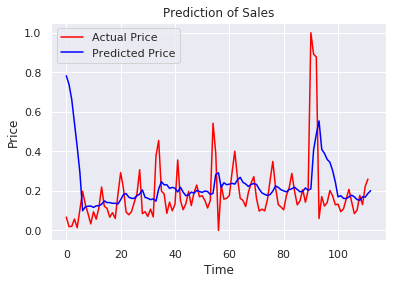

In [40]:
plt.plot(test_full[601:], color = 'red', label = 'Actual Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Prediction of Sales')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()